# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from translitua import translit

## Завантаження набору даних

In [174]:
df = pd.read_csv('./real-estate-1677255834846.csv', usecols=['residence', 'developer', 'price', 'attributes/class', 'description'])

In [175]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4138800
1,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4586175
2,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4569925
3,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4569925
4,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,5125725


In [176]:
df.shape

(18, 5)

In [177]:
df = df.dropna(subset=['attributes/class', 'description'])

In [178]:
df['class'] = df['attributes/class'].map({ 'бізнес': 1 })

In [179]:
df = df[['description', 'class']]

In [180]:
df.head()

,description,class
0,Greenville — це об'єднання житлового простору ...,1
1,Greenville — це об'єднання житлового простору ...,1
2,Greenville — це об'єднання житлового простору ...,1
3,Greenville — це об'єднання житлового простору ...,1
4,Greenville — це об'єднання житлового простору ...,1


### Транслітерування (треба саме переклад)

In [181]:
def tslt(description):
    return translit(description)

df['description'] = df['description'].map(tslt)

In [182]:
df

,description,class
0,Greenville — tse obiednannia zhytlovoho prosto...,1
1,Greenville — tse obiednannia zhytlovoho prosto...,1
2,Greenville — tse obiednannia zhytlovoho prosto...,1
3,Greenville — tse obiednannia zhytlovoho prosto...,1
4,Greenville — tse obiednannia zhytlovoho prosto...,1
5,Greenville — tse obiednannia zhytlovoho prosto...,1
6,Greenville — tse obiednannia zhytlovoho prosto...,1
7,Greenville — tse obiednannia zhytlovoho prosto...,1
8,Greenville — tse obiednannia zhytlovoho prosto...,1
9,Greenville — tse obiednannia zhytlovoho prosto...,1


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [183]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [184]:
train.shape, val.shape, test.shape

((14, 2), (2, 2), (2, 2))

In [185]:
df.head()

,description,class
0,Greenville — tse obiednannia zhytlovoho prosto...,1
1,Greenville — tse obiednannia zhytlovoho prosto...,1
2,Greenville — tse obiednannia zhytlovoho prosto...,1
3,Greenville — tse obiednannia zhytlovoho prosto...,1
4,Greenville — tse obiednannia zhytlovoho prosto...,1


In [171]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  df = dataframe['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [172]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [154]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [155]:
hub_layer = hub.KerasLayer(embed, dtype=tf.string, trainable=True)

In [160]:
# hub_layer(list(train_data)[0][0]['description'])

In [167]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [194]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [195]:
model.evaluate(train_data)

1/1 [==============================] - 0s 239ms/step - loss: 0.5589 - accuracy: 1.0000


[0.5588818788528442, 1.0]

In [197]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5589 - accuracy: 1.0000 - val_loss: 0.4951 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4951 - accuracy: 1.0000 - val_loss: 0.4374 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 933ms/step - loss: 0.4374 - accuracy: 1.0000 - val_loss: 0.3854 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.3854 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.3394 - accuracy: 1.0000 - val_loss: 0.2995 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 981ms/step - loss: 0.2995 - accuracy: 1.0000 - val_loss: 0.2639 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.2639 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 1.0000
Epoch 8/10
1/1 [===================

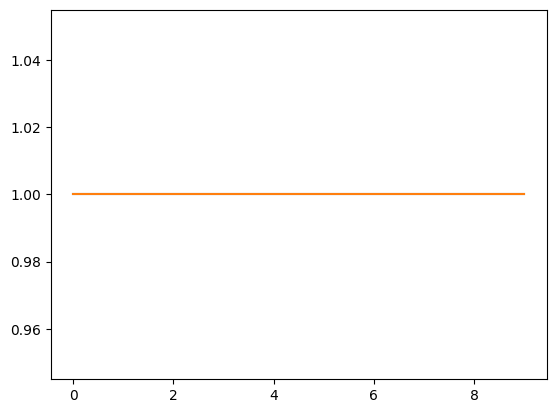

In [201]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")

plt.show()

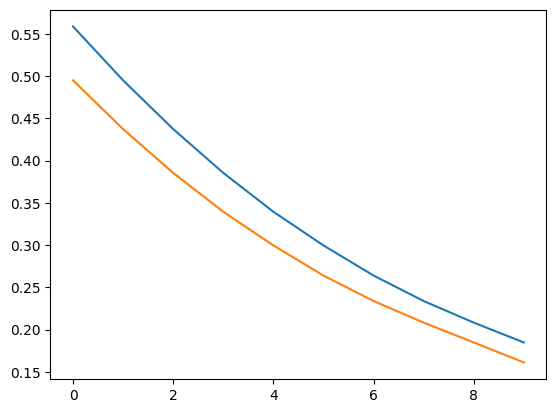

In [200]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")

plt.show()

In [202]:
model.evaluate(test_data)

1/1 [==============================] - 0s 186ms/step - loss: 0.1610 - accuracy: 1.0000


[0.16097013652324677, 1.0]

TODO: also use LSTM https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org